In [1]:
pip install pytidycensus

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pytidycensus as tc

C:\Users\metal\AppData\Local\Temp\ipykernel_35132\4052122762.py:5: UserWarning: Mapping functions unavailable due to import error: ModuleNotFoundError. To use mapping features, ensure all dependencies are properly installed: pip install pytidycensus[map]
  import pytidycensus as tc


In [3]:
tc.set_census_api_key("3d33dd56fa8e81fd42e039aadf43b9676976f27c")

variables = {
    "B01003_001E": "total_population",              
    "B01002_001E": "median_age",                    
    "B02001_002E": "white",                
    "B02001_003E": "black",  
    "B02001_004E" : "native",
    "B02001_005E" : "asian",
    "B02001_006E" : "pacific_islander",
    "B02001_007E" : "other",
    "B02001_008E" : "two_or_more_races",
    "B05001_006E" : "not_citizen",
    "B06001_013E": "born_in_nc",
    "B06001_037E": "born_outside_us",
    "B06007_005E": "english_less_than_well", 
    "B07001_001E": "geographically_mobile",
    "B07001_065E": "moved_from_diff_state",    #past year
    "B07001_081E": "moved_from_abroad",
    "B03003_003E": "hispanic",             
    "B19013_001E": "median_household_income",      
    "B15003_022E": "bachelors_degree",

    "B08301_002E": "drove_alone",
    "B08301_003E": "carpooled",
    "B08301_010E": "public_transit",
    "B08301_011E": "walked",
    "B08301_012E": "other_means",
    "B08301_013E": "worked_from_home",

    # Travel time to work
    "B08303_002E": "commute_less_5",
    "B08303_003E": "commute_5_to_9",
    "B08303_004E": "commute_10_to_14",
    "B08303_005E": "commute_15_to_19",
    "B08303_006E": "commute_20_to_24",
    "B08303_007E": "commute_25_to_29",
    "B08303_008E": "commute_30_to_34",
    "B08303_009E": "commute_35_to_39",
    "B08303_010E": "commute_40_to_44",
    "B08303_011E": "commute_45_to_59",
    "B08303_012E": "commute_60_or_more",

    "B25064_001E" : "median_gross_rent",

    "B19001_001E": "total_households",
    "B19001_002E": "income_less_than_10k",
    "B19001_003E": "income_10k_to_14_9k",
    "B19001_004E": "income_15k_to_19_9k",
    "B19001_005E": "income_20k_to_24_9k",
    "B19001_006E": "income_25k_to_29_9k",
    "B19001_007E": "income_30k_to_34_9k",
    "B19001_008E": "income_35k_to_39_9k",
    "B19001_009E": "income_40k_to_44_9k",
    "B19001_010E": "income_45k_to_49_9k",
    "B19001_011E": "income_50k_to_59_9k",
    "B19001_012E": "income_60k_to_74_9k",
    "B19001_013E": "income_75k_to_99_9k",
    "B19001_014E": "income_100k_to_124_9k",
    "B19001_015E": "income_125k_to_149_9k",
    "B19001_016E": "income_150k_to_199_9k",
    "B19001_017E": "income_200k_or_more"
    
}

year = 2023
df = tc.get_acs(
    geography="county",
    variables=list(variables.keys()),
    state="NC",
    year=year,
    output="wide",    
    geometry=True  
)

#drop columns for margin of error (not necessary)
moe_cols = [col for col in df.columns if col.endswith("e")]
df = df.drop(columns = moe_cols)


#rename columns from variable key to statistic
df = df.rename(columns={var: name for var, name in variables.items()})




Census API key has been set for this session.
Getting data from the 2019-2023 5-year ACS
Large table request: 108 variables will be retrieved in chunks


In [ ]:
# --- Ensure geopandas and pytidycensus are available, convert df to GeoDataFrame, then reorder/drop columns ---
import sys
import importlib

def _install_and_import(pkg_name, import_name=None):
    import_name = import_name or pkg_name
    try:
        return importlib.import_module(import_name)
    except Exception:
        print(f"Installing {pkg_name} ...")
        !{sys.executable} -m pip install --quiet {pkg_name}
        return importlib.import_module(import_name)

# Try to import (and install if necessary)
pd = _install_and_import("pandas")
gpd = _install_and_import("geopandas")
# shapely utilities for parsing WKT/GeoJSON-like geometry
shapely_wkt = _install_and_import("shapely.wkt", "shapely.wkt")
shapely_geom = _install_and_import("shapely.geometry", "shapely.geometry")
# pytidycensus (python wrapper for tidycensus-like functionality)
pytidycensus = _install_and_import("pytidycensus")

# ---- Now operate on df ----
if 'df' not in globals() or not isinstance(df, pd.DataFrame):
    raise RuntimeError("No pandas DataFrame named 'df' found in this notebook. Create 'df' and re-run this cell.")

# Work on a copy to avoid surprises
df_work = df.copy()

# 1) Drop GEO_ID if present
df_work = df_work.drop(columns=['GEOID'])
print("Dropped 'GEO_ID' column.")

# 2) If there's a 'geometry' column but it's not proper shapely geometries, try to convert
if 'geometry' in df_work.columns:
    # If it's already a GeoSeries dtype (shapely objects), we'll be fine
    geom_sample = None
    try:
        geom_sample = df_work['geometry'].dropna().iloc[0]
    except Exception:
        geom_sample = None

    if geom_sample is not None:
        # If sample is a string (likely WKT), convert all using shapely.wkt.loads
        if isinstance(geom_sample, str):
            print("Converting 'geometry' column from WKT strings to shapely geometries...")
            df_work['geometry'] = df_work['geometry'].apply(lambda v: shapely_wkt.loads(v) if pd.notna(v) else None)
        # If sample is a dict (GeoJSON-like), convert using shapely.geometry.shape
        elif isinstance(geom_sample, dict):
            from shapely.geometry import shape as _shape
            print("Converting 'geometry' column from GeoJSON-like dicts to shapely geometries...")
            df_work['geometry'] = df_work['geometry'].apply(lambda v: _shape(v) if pd.notna(v) else None)
        # else assume it's already shapely geometry objects

    # Create a GeoDataFrame (this will set the geometry column)
    try:
        gdf = gpd.GeoDataFrame(df_work, geometry='geometry', crs=None)
        df_work = gdf
        print("Converted to GeoDataFrame (geometry set).")
    except Exception as e:
        print("Warning: failed to cast to GeoDataFrame automatically:", e)
        # proceed with df_work as-is (will still reorder columns)

# 3) Move NAME to the front if present
if 'NAME' in df_work.columns:
    cols = ['NAME'] + [c for c in df_work.columns if c != 'NAME']
    df_work = df_work.loc[:, cols]
    print("Moved 'NAME' to front.")

# 4) Move geometry to the end if present
if 'geometry' in df_work.columns:
    cols = [c for c in df_work.columns if c != 'geometry'] + ['geometry']
    df_work = df_work.loc[:, cols]
    print("Moved 'geometry' to the end.")

# 5) Save back to global 'df' (keeping GeoDataFrame if created)
globals()['df'] = df_work

print("\n✅ 'df' updated. New column order:")
print(list(df_work.columns))

# Optional: how to set census API key for pytidycensus (uncomment and set your key)
# import os
# os.environ['CENSUS_API_KEY'] = "YOUR_CENSUS_API_KEY_HERE"
# If pytidycensus needs a specific function to set a key, consult its docs; the environment variable above is common.
df

Dropped 'GEO_ID' column.
Converted to GeoDataFrame (geometry set).
Moved 'NAME' to front.
Moved 'geometry' to the end.

✅ 'df' updated. New column order:
['NAME', 'NAMELSAD', 'total_population', 'median_age', 'white', 'black', 'native', 'asian', 'pacific_islander', 'other', 'two_or_more_races', 'not_citizen', 'born_in_nc', 'born_outside_us', 'english_less_than_well', 'geographically_mobile', 'moved_from_diff_state', 'moved_from_abroad', 'hispanic', 'median_household_income', 'bachelors_degree', 'drove_alone', 'carpooled', 'public_transit', 'walked', 'other_means', 'county', 'worked_from_home', 'commute_less_5', 'commute_5_to_9', 'commute_10_to_14', 'commute_15_to_19', 'commute_20_to_24', 'commute_25_to_29', 'commute_30_to_34', 'commute_35_to_39', 'commute_40_to_44', 'commute_45_to_59', 'commute_60_or_more', 'median_gross_rent', 'total_households', 'income_less_than_10k', 'income_10k_to_14_9k', 'income_15k_to_19_9k', 'income_20k_to_24_9k', 'income_25k_to_29_9k', 'income_30k_to_34_9k', '

,NAME,NAMELSAD,total_population,median_age,white,black,native,asian,pacific_islander,other,two_or_more_races,not_citizen,born_in_nc,born_outside_us,english_less_than_well,geographically_mobile,moved_from_diff_state,moved_from_abroad,hispanic,median_household_income,bachelors_degree,drove_alone,carpooled,public_transit,walked,other_means,county,worked_from_home,commute_less_5,commute_5_to_9,commute_10_to_14,commute_15_to_19,commute_20_to_24,commute_25_to_29,commute_30_to_34,commute_35_to_39,commute_40_to_44,commute_45_to_59,commute_60_or_more,median_gross_rent,total_households,income_less_than_10k,income_10k_to_14_9k,income_15k_to_19_9k,income_20k_to_24_9k,income_25k_to_29_9k,income_30k_to_34_9k,income_35k_to_39_9k,income_40k_to_44_9k,income_45k_to_49_9k,income_50k_to_59_9k,income_60k_to_74_9k,income_75k_to_99_9k,income_100k_to_124_9k,income_125k_to_149_9k,income_150k_to_199_9k,income_200k_or_more,geometry
0,"Onslow County, North Carolina",Onslow County,208537,27.1,144394,26157,1629,3809,248,5509,26791,3138,68701,4810,3222,204415,19185,2004,28739,64568,20233,85228,71577,121,106,0,133,0,5669,14425,14182,14185,13613,7590,11447,1772,3370,5605,2719,1198,72516,3389,2477,2622,2343,3324,2891,2613,4468,3092,6101,8988,10491,7370,4427,4436,3484,"MULTIPOLYGON (((-77.17131 34.62567, -77.16931 ..."
1,"Ashe County, North Carolina",Ashe County,26831,49.8,25215,289,115,100,0,175,937,385,18176,122,387,26552,416,8,1569,50827,2977,9665,8627,9,0,0,009,0,173,1155,1564,1716,1174,699,1531,289,239,712,274,774,11999,768,617,704,541,762,592,748,482,679,1160,1150,1374,716,654,730,322,"POLYGON ((-81.74065 36.41314, -81.7373 36.4135..."
2,"Stokes County, North Carolina",Stokes County,44889,47.6,40992,1543,88,16,0,507,1743,189,32100,308,199,44598,254,56,1621,60039,4097,18139,16659,5,5,0,169,0,766,1281,1771,1551,2189,1400,3241,947,1018,2653,1060,766,19374,824,1012,784,1042,590,878,903,1128,756,1758,2358,3020,1962,739,977,643,"POLYGON ((-80.4502 36.3284, -80.44991 36.33899..."
3,"Currituck County, North Carolina",Currituck County,29612,41.7,25360,1509,50,300,0,692,1701,307,6042,384,350,29371,1797,0,1444,91548,4357,13646,11947,10,10,0,053,0,342,1190,885,1183,1077,762,1626,818,825,2449,2118,1126,11497,321,270,327,265,388,301,366,201,233,729,1193,1384,1735,1154,1311,1319,"POLYGON ((-76.3133 36.55055, -76.31322 36.5505..."
4,"Swain County, North Carolina",Swain County,14065,42.6,8601,212,4127,56,10,33,1026,97,9641,174,51,13919,666,35,718,55429,1196,5110,4624,74,74,0,173,0,130,898,1045,958,931,61,750,45,43,213,184,715,5837,367,437,261,360,279,234,366,151,209,421,397,626,808,364,311,246,"POLYGON ((-83.94939 35.46116, -83.94299 35.465..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,"Duplin County, North Carolina",Duplin County,49053,40.7,28190,11184,200,299,58,5879,3243,4488,34241,621,4518,48706,535,133,11137,51880,4167,19765,17311,2,2,0,061,0,884,2541,2315,2581,2753,1186,2074,503,545,2179,1798,815,20096,993,1382,1143,867,1134,1313,1027,1153,687,1360,2062,2827,1677,1015,828,628,"POLYGON ((-78.19854 34.74201, -78.19848 34.742..."
96,"Alexander County, North Carolina",Alexander County,36440,43.8,31804,1468,331,392,0,809,1636,312,26512,270,555,36181,524,186,1950,65268,2747,14515,13066,0,0,0,003,0,336,1332,1873,2016,2404,1190,2087,610,442,1070,763,745,13895,446,674,426,834,515,726,508,442,590,1243,1733,2505,1070,816,764,603,"POLYGON ((-81.3436 35.82699, -81.33777 35.8569..."
97,"Caldwell County, North Carolina",Caldwell County,80618,45.5,69846,3319,72,403,81,3071,3826,1846,60620,544,1278,80034,945,69,5160,55401,7571,32969,29188,1,0,0,027,0,1063,3225,5308,4848,4509,3048,4445,1399,1181,2250,990,735,32766,1146,1612,1857,1702,1754,1822,1806,1727,1552,2683,2931,4115,2925,2177,1962,995,"POLYGON ((-81.81052 36.11151, -81.77993 36.114..."
98,"Wake County, North Carolina",Wake County,115

<Axes: >

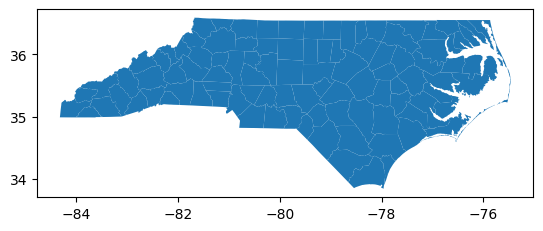

In [5]:
df.plot()